In [37]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [38]:
features_raw = pd.read_csv('parliament.csv')

In [39]:
titles = features_raw.BillTitle
days_until_question_close = (datetime.datetime(2017,10,1) - datetime.datetime(2017,4,13)).days
days_raw = features_raw.DaysUntilRoyalAssent
fast = days_raw < days_until_question_close

In [40]:
X_train, X_test, y_train, y_test = train_test_split(titles, fast, test_size=0.2, random_state=0)

In [41]:
vect = CountVectorizer()

In [42]:
X_train_counts = vect.fit_transform(X_train)
X_test_counts = vect.transform(X_test)

In [74]:
tfidf = TfidfTransformer(use_idf=False)

In [75]:
tf_transformer = tfidf.fit(X_train_counts)

In [76]:
X_train_tf = tf_transformer.transform(X_train_counts)
X_test_tf = tf_transformer.transform(X_test_counts)

In [77]:
logr = LogisticRegression()

In [78]:
logr.fit(X_train_tf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
preds = logr.predict(X_test_counts)

In [80]:
print(accuracy_score(y_test, preds))
print(roc_auc_score(y_test, preds))

0.787037037037
0.771914132379


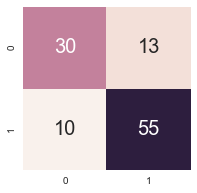

In [50]:
conf_matrix = confusion_matrix(y_test, preds)
plt.rcParams['figure.figsize']=(3,3)
sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 20}, cbar=False);

## Grid Search

In [51]:
from sklearn.grid_search import GridSearchCV 
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import make_scorer 

def fit_model(X, y):
    cv_sets = ShuffleSplit(X.shape[0], n_iter=5, test_size=0.10, random_state=0)
    # cv_sets = StratifiedShuffleSplit(y, test_size=0.10)
    
    clf = LogisticRegression()
    params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    scorer = make_scorer(roc_auc_score)
    grid = GridSearchCV(clf, params, scorer)
    grid = grid.fit(X, y)
    return grid.best_estimator_

In [52]:
reg = fit_model(X_train_tf, y_train)

In [53]:
preds_grid = reg.predict(X_test_tf)

In [54]:
print(accuracy_score(y_test, preds_grid))
print(roc_auc_score(y_test, preds_grid))

0.740740740741
0.729516994633


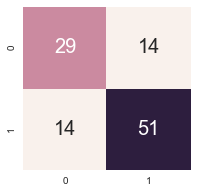

In [55]:
conf_matrix = confusion_matrix(y_test, preds_grid)
plt.rcParams['figure.figsize']=(3,3)
sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 20}, cbar=False);

In [56]:
text_fast = [features_raw.loc[i]['BillTitle'] for i in range(len(features_raw)) if fast[i]]
text_slow = [features_raw.loc[i]['BillTitle'] for i in range(len(features_raw)) if not fast[i]]
text_fast_string = ' '.join(text_fast)
text_slow_string = ' '.join(text_slow)

In [57]:
stopwords = set(STOPWORDS)
stopwords.add("Act")
stopwords.add("amend")

In [58]:
wc = WordCloud(background_color="white", stopwords=stopwords)
wc.generate(text_fast_string)

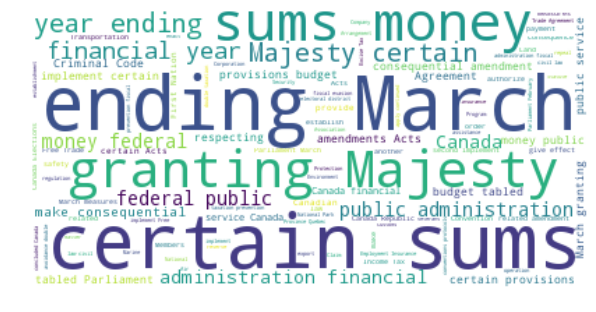

In [60]:
rcParams['figure.figsize'] = 10, 20
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

In [26]:
wc.generate(text_slow_string)

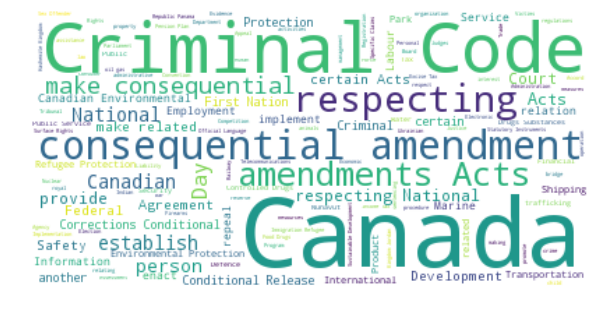

In [27]:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

## Bill C-45

In [28]:
np.set_printoptions(precision=3)
bill_C45_title = ["An Act respecting cannabis and to amend the Controlled Drugs and Substances Act, the Criminal Code and other Acts"]
bill_C45_counts = vect.transform(bill_C45_title)
bill_C45_tf = tf_transformer.transform(bill_C45_counts)

In [29]:
no1, yes1 = logr.predict_proba(bill_C45_tf)[0] * 100

In [30]:
# Tuned 
no2, yes2 = reg.predict_proba(bill_C45_tf)[0] * 100

### Will Canada legalise recreational marijuana nationally before 1 October 2017?

In [31]:
print("Yes: {}% No: {}%".format(int(yes1), int(no1)))

Yes: 24% No: 75%


In [32]:
print("Yes: {}% No: {}%".format(int(yes2), int(no2)))

Yes: 7% No: 92%


In [35]:
sum(fast)/len(fast)

0.5940409683426443